<a href="https://colab.research.google.com/github/EjbejaranosAI/AI_trends_2023/blob/main/MBM_AI_for__analysis_of_brain_image_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AI/ML for the analysis of brain imaging data.
## MBM (Minds, brains and machines)
## Author: Edison Jair Bejarano Sepulveda

### Quantitative susceptibility mapping - QSM DATA from 2018 reconstruction challenge

##### *Download data*

In [1]:
# Downloading data
!wget -nc http://www.neuroimaging.at/media/qsm/20170327_qsm2016_recon_challenge.zip
!unzip -uo 20170327_qsm2016_recon_challenge.zip

--2023-06-09 03:38:45--  http://www.neuroimaging.at/media/qsm/20170327_qsm2016_recon_challenge.zip
Resolving www.neuroimaging.at (www.neuroimaging.at)... 81.19.159.35
Connecting to www.neuroimaging.at (www.neuroimaging.at)|81.19.159.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244982259 (234M) [application/zip]
Saving to: ‘20170327_qsm2016_recon_challenge.zip’

20170327_qsm2016_re 100%[===================>] 233.63M  13.7MB/s    in 19s     

2023-06-09 03:39:05 (12.5 MB/s) - ‘20170327_qsm2016_recon_challenge.zip’ saved [244982259/244982259]

Archive:  20170327_qsm2016_recon_challenge.zip
   creating: 20170327_qsm2016_recon_challenge/
   creating: 20170327_qsm2016_recon_challenge/data/
  inflating: 20170327_qsm2016_recon_challenge/data/chi_33.mat  
  inflating: 20170327_qsm2016_recon_challenge/data/chi_33.nii.gz  
  inflating: 20170327_qsm2016_recon_challenge/data/chi_cosmos.mat  
  inflating: 20170327_qsm2016_recon_challenge/data/chi_cosmos.nii.gz  
  infl

##### *Libraries*

In [2]:
!pip install -q tensorflow==2.0.0-alpha0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.0.0-alpha0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0, 2.13.0rc1)
ERROR: No matching distribution found for tensorflow==2.0.0-alpha0


In [3]:
# Importing libraries
import os
import pickle
import numpy as np
import nibabel as nib
import tensorflow as tf
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib import transforms

import tensorflow.keras.losses as losses
import tensorflow.keras.metrics as metrics

##### *Utils functions*

In [4]:
# Utils functions

#--------------------------#
# Plot view slices brain 3D
#--------------------------#
def view_slices_3d(image_3d, slice_nbr, vmin, vmax, title=''):
    fig = plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=16)
    
    plt.subplot(131)
    image = np.take(image_3d, slice_nbr, 2)
    plt.imshow(image, vmin=vmin, vmax=vmax, cmap='gray')
    plt.title('Axial')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    
    plt.subplot(132)
    image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 1),90)
    plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap='gray')
    plt.title('Coronal')
    plt.xlabel('X-axis')
    plt.ylabel('Z-axis')
    
    plt.subplot(133)
    image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 0),90)
    plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap='gray')
    plt.title('Sagittal')
    plt.xlabel('Y-axis')
    plt.ylabel('Z-axis')
    
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Intensity', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()

#--------------------------#
#       Random size 
#--------------------------#
def creating_random_size(min_size, max_size):
  random_size = np.random.randint(low = min_size, high = max_size)
  return random_size



#--------------------------#
# Susceptibility simulation
#--------------------------#
def simulate_susceptibility_sources(simulation_dim = 160,
                                    rectangles_total = 100, 
                                    spheres_total = 80, 
                                    sus_std = 1,
                                    shape_size_min_factor= 0.01,
                                    shape_size_max_factor = 0.5):
  
  temp_sources = np.zeros((simulation_dim, simulation_dim, simulation_dim))

  for shapes in range(rectangles_total):
    shrink_factor = 1/((shapes/rectangles_total+1))
    shape_size_min = np.floor(simulation_dim * shrink_factor * shape_size_min_factor)
    shape_size_max = np.floor(simulation_dim * shrink_factor * shape_size_max_factor)
    print(f"\n ------- Shape Min size: {shape_size_min} ------- \n")
    print(f"\n ------- Shape Max size: {shape_size_max} ------- \n")

    susceptibility_value = np.random.normal(loc=0.0, scale=sus_std)
    # Creating random sizes
    random_sizex = creating_random_size(shape_size_min,shape_size_max)
    random_sizey = creating_random_size(shape_size_min,shape_size_max)
    random_sizez = creating_random_size(shape_size_min,shape_size_max)
    # Getting axis positions
    x_pos = np.random.randint(simulation_dim)
    y_pos = np.random.randint(simulation_dim)
    z_pos = np.random.randint(simulation_dim)

    x_pos_max = x_pos + random_sizex
    if x_pos_max >= simulation_dim:
      x_pos_max = simulation_dim

    y_pos_max = y_pos + random_sizey
    if y_pos_max >= simulation_dim:
      y_pos_max = simulation_dim 

    z_pos_max = z_pos + random_sizez
    if z_pos_max >= simulation_dim:
      z_pos_max = simulation_dim

    temp_sources[x_pos:x_pos_max, y_pos:y_pos_max, z_pos:z_pos_max] = susceptibility_value

  return temp_sources

import numpy as np



#--------------------------#
#     Dipole kernel 3D
#--------------------------#
def create_dipole_kernel_3D(data_shape, voxel_size, b_vec):
    # Calculate the field of view
    fov = np.array(data_shape) * np.array(voxel_size)
    
    # Generate the x, y, and z coordinates of the image grid and
    # Create a meshgrid of the x, y, and z coordinates
    ry, rx, rz = np.meshgrid(np.arange(-data_shape[1] // 2, data_shape[1] // 2),
                          np.arange(-data_shape[0] // 2, data_shape[0] // 2),
                          np.arange(-data_shape[2] // 2, data_shape[2] // 2))
    
    # Normalize the x, y, and z coordinates by the field of view
    rx, ry, rz = rx / fov[0], ry / fov[1], rz / fov[2]
    
    # Calculate the squared distance from the origin
    sq_dist = rx ** 2 + ry ** 2 + rz ** 2
    sq_dist[sq_dist == 0] = 1e-6
    
    # Calculate the dipole kernel
    d2 = ((b_vec[0] * rx + b_vec[1] * ry + b_vec[2] * rz) ** 2) / sq_dist
    kernel = (1/3 - d2)
    
    return kernel


#--------------------------------------#
#   Forward convolution with padding
#--------------------------------------#
def simulate_mri_tissue_phase(sample, padding=20):
    # Pad the sample to avoid wrap-around at the edges
    padded_sample = np.pad(sample, pad_width=padding, mode='constant')

    # Scaling factor for Fourier transform normalization
    scaling = np.sqrt(padded_sample.size)
    
    # Perform Fourier transform of the padded sample
    sample_fft = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(padded_sample))) / scaling

    # Generate a 3D dipole kernel
    dipole_kernel = create_dipole_kernel_3D(padded_sample.shape, voxel_size=1, b_vec=[0, 0, 1])

    # Multiply the Fourier transform of the sample by the dipole kernel
    sample_fft_conv = sample_fft * dipole_kernel

    # Perform inverse Fourier transform and rescale by the scaling factor
    tissue_phase_unscaled = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(sample_fft_conv)))
    tissue_phase = np.real(tissue_phase_unscaled * scaling)

    # Crop the padded regions to match the original sample size
    tissue_phase_cropped = tissue_phase[padding:-padding, padding:-padding, padding:-padding]

    return tissue_phase_cropped


#--------------------------------------#
#     Forward convolution no padding
#--------------------------------------#
def simulate_mri_tissue_phase_no_padding(sample):
    # Scaling factor for Fourier transform normalization
    scaling = np.sqrt(sample.size)
    
    # Perform Fourier transform of the sample
    sample_fft = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(sample))) / scaling

    # Generate a 3D dipole kernel
    dipole_kernel = create_dipole_kernel_3D(sample.shape, voxel_size=1, b_vec=[0, 0, 1])

    # Multiply the Fourier transform of the sample by the dipole kernel
    sample_fft_conv = sample_fft * dipole_kernel

    # Perform inverse Fourier transform and rescale by the scaling factor
    tissue_phase = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(sample_fft_conv)))
    tissue_phase = np.real(tissue_phase * scaling)

    return tissue_phase


In [5]:
#--------------------------------------#
#     Creating batches for data
#--------------------------------------#
def create_batch(dimension, patch_idx, gt_full, fw_full):
    # Get the dimensions of the ground truth data
    x_max, y_max, z_max = gt_full.shape

    # Generate random indices for selecting the patch
    random_indices = np.random.choice(x_max - dimension, 3)
    randomX, randomY, randomZ = random_indices

    # Extract the patch using tuple indexing
    gt_patch = gt_full[randomX:randomX + dimension, randomY:randomY + dimension, randomZ:randomZ + dimension]
    fw_patch = fw_full[randomX:randomX + dimension, randomY:randomY + dimension, randomZ:randomZ + dimension]

    # Return the extracted patches
    return gt_patch, fw_patch

##### Images exploration by views

<ipython-input-6-b42306d4fe86>:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  tissue_phase_brain = nib.load('/content/20170327_qsm2016_recon_challenge/data/phs_tissue.nii.gz').get_data()
<ipython-input-6-b42306d4fe86>:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  gold_standard_qsm = nib.load('/content/20170327_qsm2016_recon_challenge/data/chi_33.nii.gz').get_data()


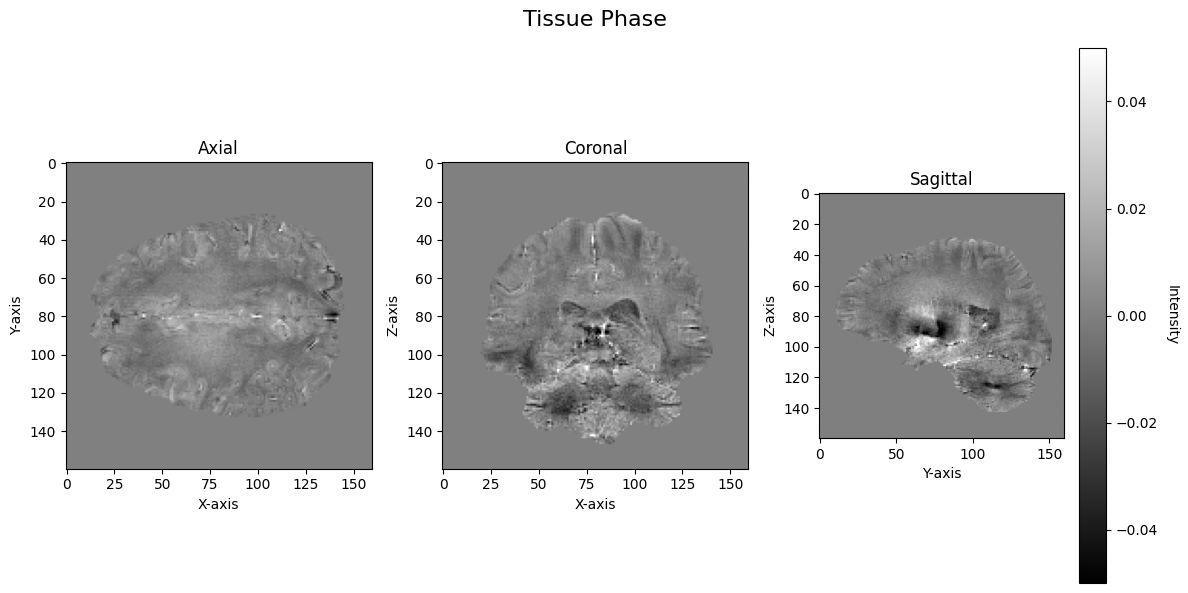

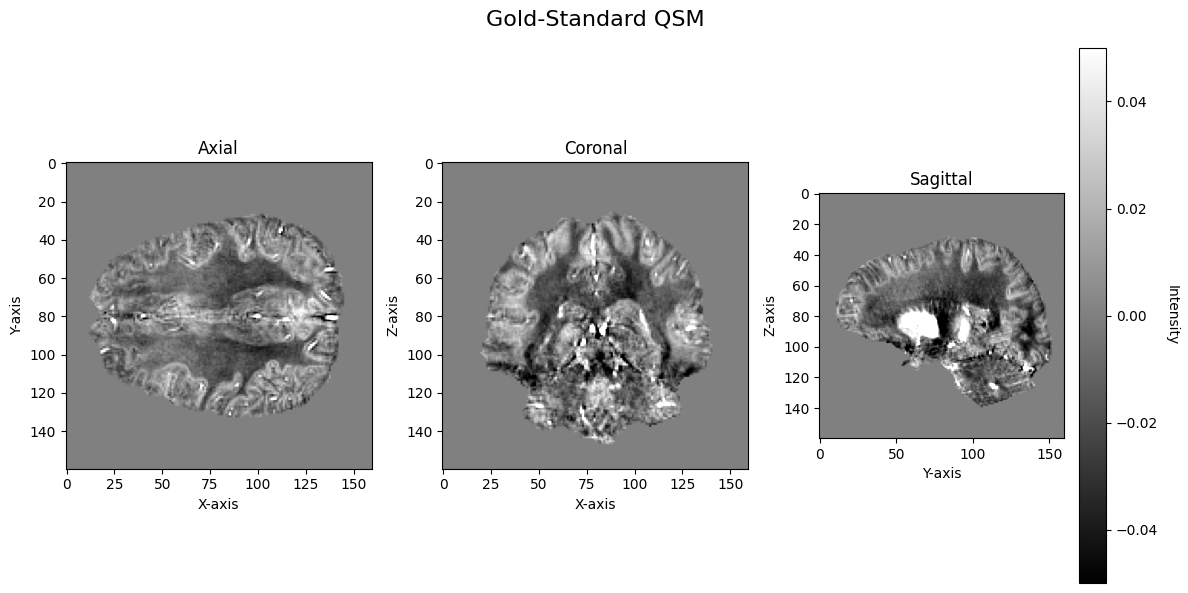

In [6]:
# Loading images by nib library
tissue_phase_brain = nib.load('/content/20170327_qsm2016_recon_challenge/data/phs_tissue.nii.gz').get_data()
gold_standard_qsm = nib.load('/content/20170327_qsm2016_recon_challenge/data/chi_33.nii.gz').get_data()


view_slices_3d(tissue_phase_brain, slice_nbr=100, vmin=-0.05, vmax=0.05, title='Tissue Phase')
view_slices_3d(gold_standard_qsm, slice_nbr=100, vmin=-0.05, vmax=0.05, title='Gold-Standard QSM') 

##### *Simulation of susceptibility distribution*


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 160.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 157.0 ------- 


 ------- Shape 

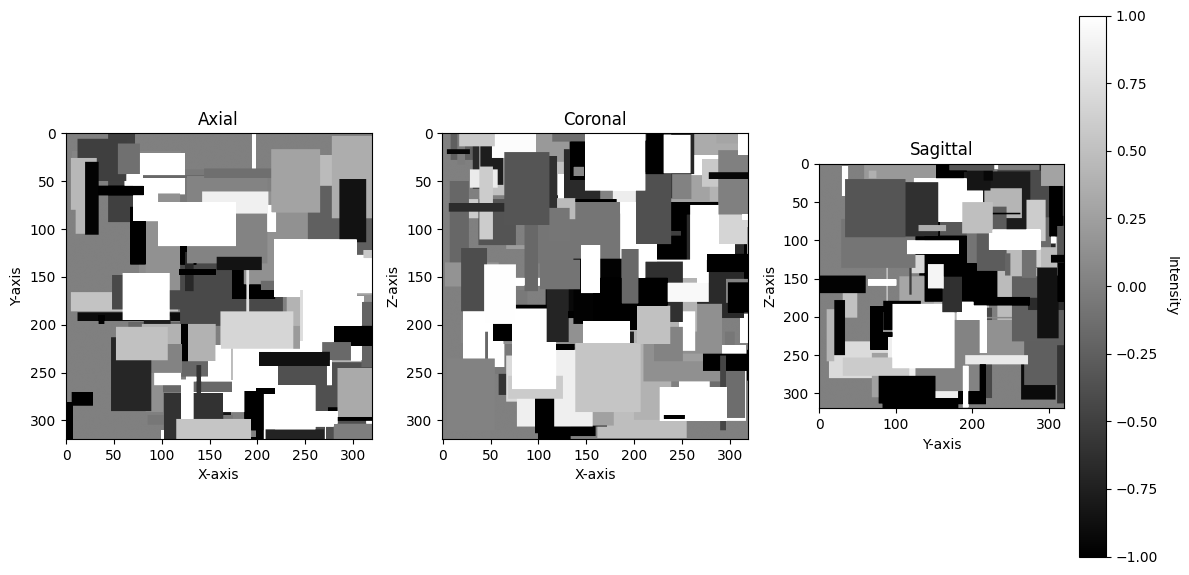

In [7]:
# sim_gt_full = simulated_ground_truth
sim_gt_full = simulate_susceptibility_sources(simulation_dim = 320, rectangles_total = 800, spheres_total = 80,)
view_slices_3d(sim_gt_full, slice_nbr=100, vmin=-1, vmax=1)

##### *Convolve susceptibility distribution with dipole kernel to yield tissue phase* 


Dipole Kernel: The code generates a 3D dipole kernel using the generate_3d_dipole_kernel function. This kernel represents the response of a magnetic dipole in a magnetic resonance imaging (MRI) system. It is used to model the interaction between the sample and the imaging system.

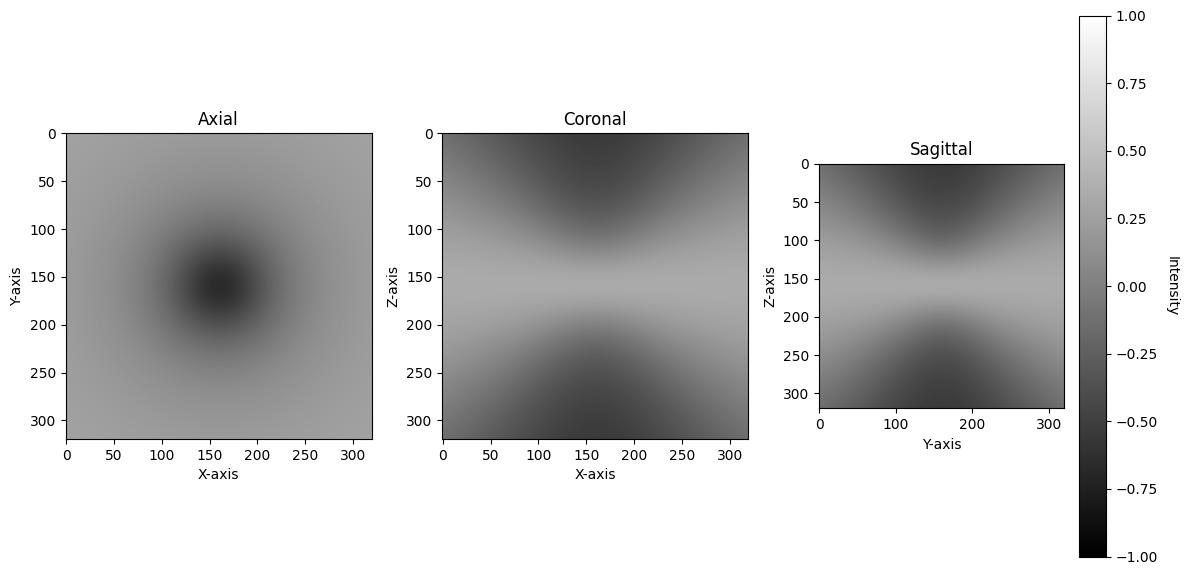

In [8]:
dipole_kernel3d = create_dipole_kernel_3D(sim_gt_full.shape, voxel_size=1, b_vec=[0, 0, 1])
view_slices_3d(dipole_kernel3d, slice_nbr=100, vmin=-1, vmax=1)

- **Fourier Transform:** The code uses the np.fft.fftn function to compute the N-dimensional Fast Fourier Transform (FFT) of the input sample. The np.fft.fftshift function is used to shift the zero-frequency component to the center of the spectrum. This is a common step in Fourier analysis to obtain a more intuitive representation of the data.

- **Inverse Fourier Transform:** The code uses the np.fft.ifftn function to compute the N-dimensional Inverse FFT (IFFT) of the transformed sample. Again, the np.fft.fftshift function is used to shift the zero-frequency component back to the corners of the spectrum.
Scaling: To ensure proper normalization, the code divides the transformed samples by the square root of the sample size (scaling). This step is necessary to preserve the total energy of the data during the Fourier transformations.



- **Multiplication and Convolution:** The code multiplies the transformed sample by the dipole kernel in the Fourier domain. This multiplication corresponds to a convolution operation in the spatial domain. By performing the multiplication in the Fourier domain, the code exploits the convolution theorem, which states that multiplication in the Fourier domain is equivalent to convolution in the spatial domain.

- **Inverse Transform and Rescaling:** After multiplying the transformed sample by the dipole kernel, the code applies the inverse Fourier transform to obtain the spatial representation of the result. The resulting tissue phase is then rescaled by the scaling factor to restore the proper amplitude of the data.

- **Padding and Cropping:** In the forward_convolution_padding function, the input sample is padded with zeros before the Fourier transform to avoid wrap-around artifacts at the edges. After the inverse transform, the padded regions are cropped to match the size of the original sample.

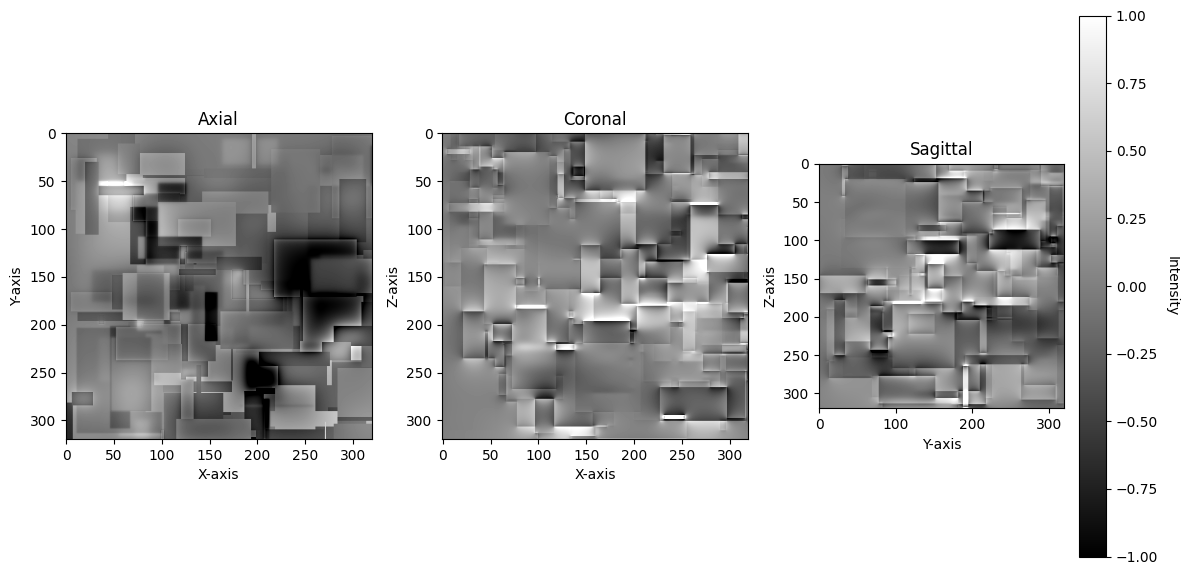

In [9]:
# Simulate tissue phase with padding
simulated_tissue_phase_full = simulate_mri_tissue_phase(sim_gt_full)
view_slices_3d(simulated_tissue_phase_full, slice_nbr=100, vmin=-1, vmax=1)

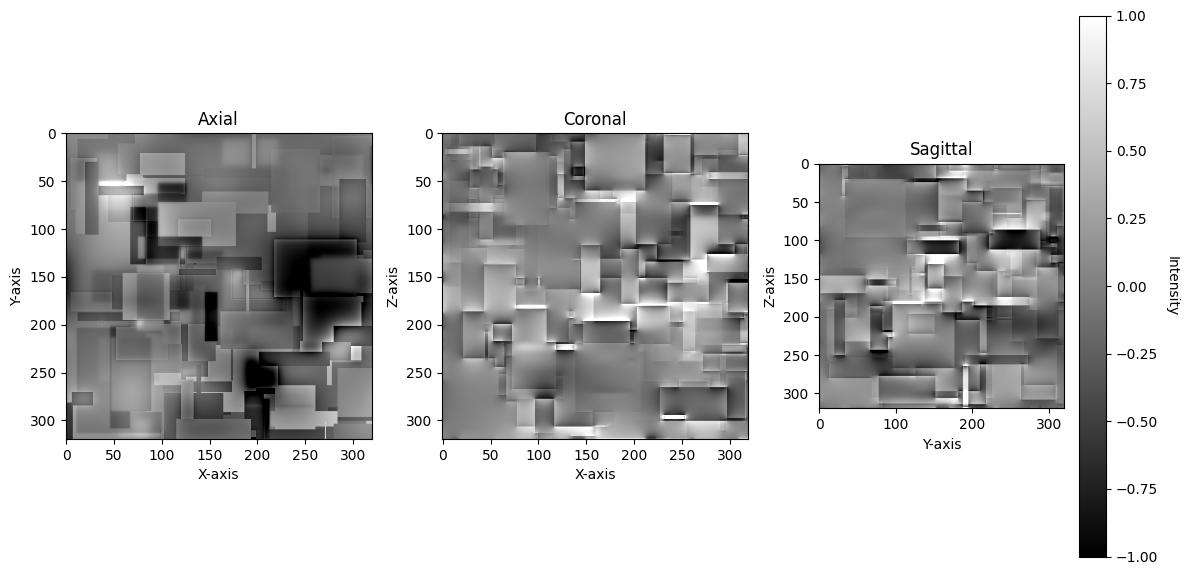

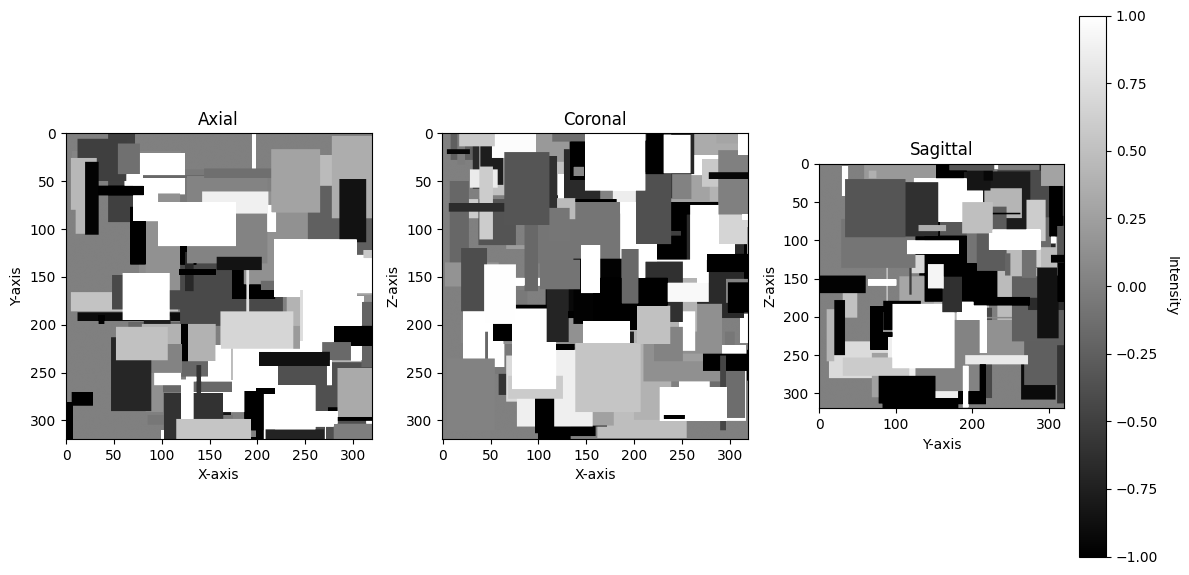

In [10]:
# Simulate tissue phase without padding
simulated_tissue_phase = simulate_mri_tissue_phase_no_padding(sim_gt_full)
view_slices_3d(simulated_tissue_phase, slice_nbr=100, vmin=-1, vmax=1)
view_slices_3d(sim_gt_full, slice_nbr=100, vmin=-1, vmax=1)

#### Training a model to invert the dipole convolution 

###### Prepare patches for training

In [11]:
total_patches = 500
training_dim = 64

# Split patches to train from our simulations in ground truth and forward
simulation_gt_patches = np.zeros((total_patches, training_dim, training_dim, training_dim))
simulation_fw_patches = np.zeros((total_patches, training_dim, training_dim, training_dim))


for patch_idx in range(total_patches):
  simulation_gt_patches[patch_idx, :, :, :], simulation_fw_patches[patch_idx, :, :, :] = create_batch(training_dim, patch_idx,sim_gt_full,simulated_tissue_phase)


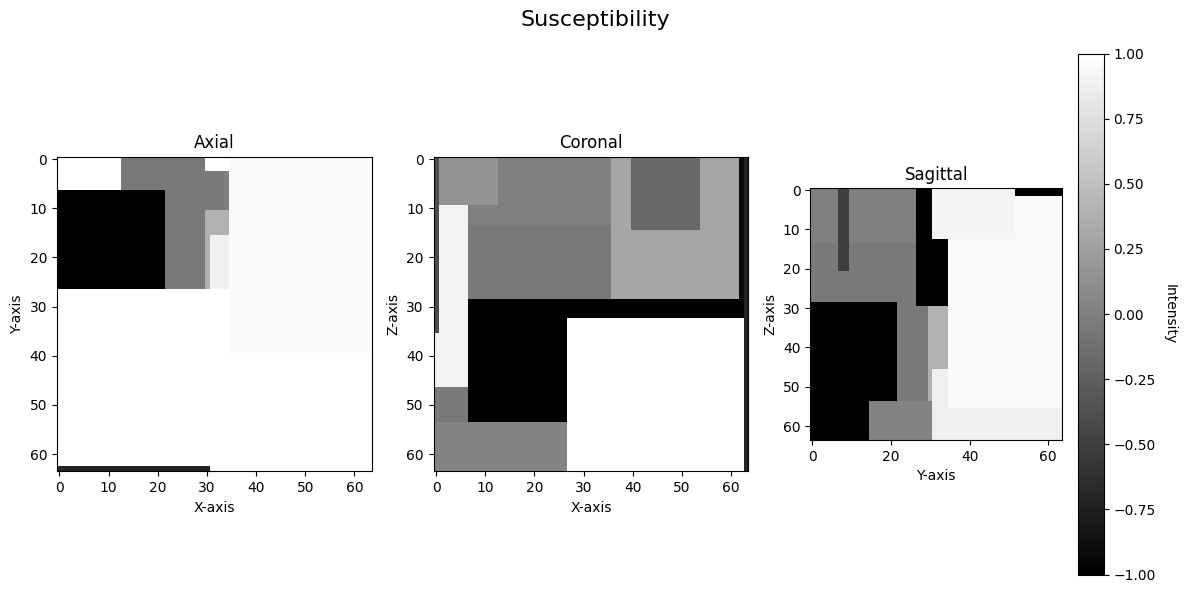

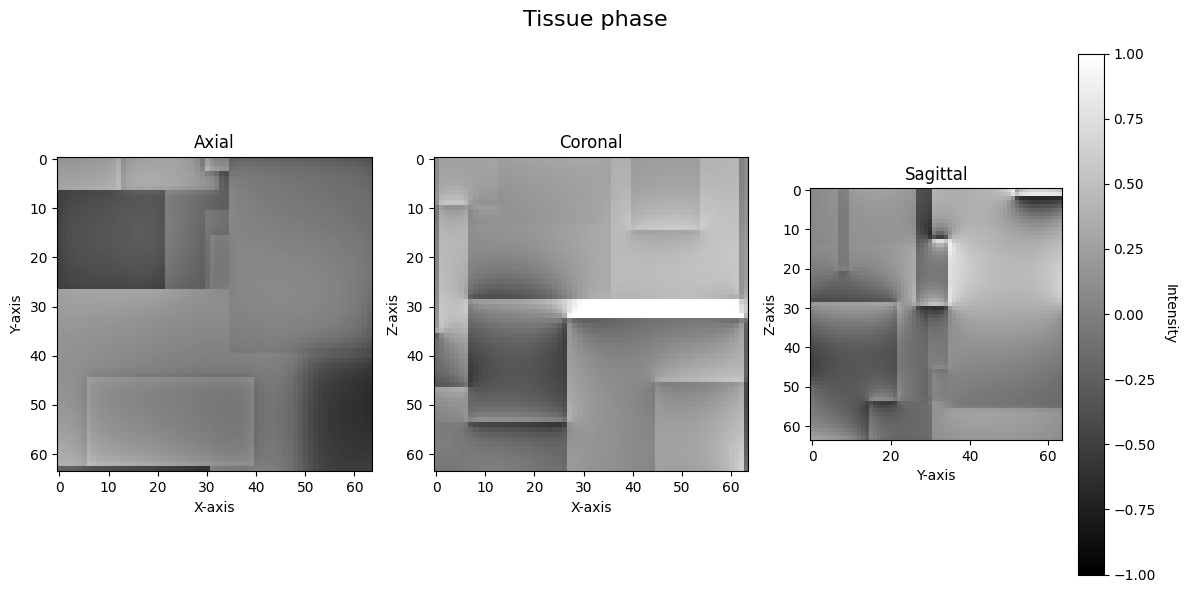

In [12]:
patch_idx = 40
view_slices_3d(simulation_gt_patches[patch_idx, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Susceptibility')
view_slices_3d(simulation_fw_patches[patch_idx, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Tissue phase')

##### Building architectures


In [13]:
# Print TensorFlow version
print(tf.__version__)

# Check GPU device availability
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print('Running without GPU acceleration.')

2.12.0
Found GPU at: /device:GPU:0


###### Utils for architectures

In [14]:
# Utils function to construct the model

def downsample(filters, kernel_size, apply_batch_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Conv3D(filters, kernel_size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_batch_norm:
        block.add(tf.keras.layers.BatchNormalization())
    block.add(tf.keras.layers.LeakyReLU())

    return block


def upsample(filters, kernel_size, apply_dropout=False, apply_batch_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Conv3DTranspose(filters, kernel_size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_batch_norm:
        block.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        block.add(tf.keras.layers.Dropout(0.5))
    block.add(tf.keras.layers.ReLU())

    return block


class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch+1}:")
        print(f"  - Loss: {logs['loss']:.4f}")
        print(f"  - Accuracy: {logs['mean_squared_error']:.4f}")
        print(f"  - Val Loss: {logs['val_loss']:.4f}")
        print(f"  - Val Accuracy: {logs['val_mean_squared_error']:.4f}")


In [15]:
# Testing downsample and upsample functions
inp = simulation_fw_patches[0,:,:,:]
print(f"Origianl shape in fw_pathces: {inp.shape}")
inp = tf.expand_dims(inp,0)
print(f"Expanding shape in fw_pathces first position: {inp.shape}")
inp = tf.expand_dims(inp,4)
print(f"Expanding shape in fw_pathces last position: {inp.shape}")

# Downsample
#(batch,x,y,z,channel)
down_sample = downsample(filters=8, kernel_size=4)
reduction = down_sample(inp)
print(f"Shape in fw_pathces after downsample: {reduction.shape}")

#Upsample
up_sample = upsample(filters=8, kernel_size=4)
expansion = up_sample(reduction)
print(f"Shape in fw_pathces after upsample: {expansion.shape}")

Origianl shape in fw_pathces: (64, 64, 64)
Expanding shape in fw_pathces first position: (1, 64, 64, 64)
Expanding shape in fw_pathces last position: (1, 64, 64, 64, 1)
Shape in fw_pathces after downsample: (1, 32, 32, 32, 8)
Shape in fw_pathces after upsample: (1, 64, 64, 64, 8)


###### ***Parameters***

In [16]:
EPOCHS = 500
PERIOD_TO_STORE = 25
OUTPUT_CHANNELS = 1

###### ***Model 1 - Architecture***

In [17]:
def model_1(filter_base=32, kernel_size=3):
    # Define the downsample blocks
    down_stack = [
        downsample(filter_base, kernel_size, apply_batch_norm=False),  # (base, 32, 32, 32, 64)
        downsample(filter_base * 2, kernel_size),                      # (base, 16, 16, 16, 128)
        downsample(filter_base * 3, kernel_size),                      # (base, 8, 8, 8, 256)
        downsample(filter_base * 4, kernel_size),                      # (base, 4, 4, 4, 512)
        downsample(filter_base * 5, kernel_size),                      # (base, 2, 2, 2, 1024)
    ]

    # Define the upsample blocks
    up_stack = [
        upsample(filter_base * 5, kernel_size, apply_dropout=True),     # (base, 4, 4, 4, 1024)
        upsample(filter_base * 4, kernel_size, apply_dropout=True),     # (base, 8, 8, 8, 512)
        upsample(filter_base * 3, kernel_size, apply_dropout=True),     # (base, 16, 16, 16, 256)
        upsample(filter_base * 2, kernel_size, apply_dropout=True),     # (base, 32, 32, 32, 128)
    ]

    # Define the final layer
    initializer = tf.random_normal_initializer(0., 0.02)
    final_layer = tf.keras.layers.Conv3DTranspose(OUTPUT_CHANNELS,
                                                  kernel_size,
                                                  strides=2,
                                                  padding='same',
                                                  kernel_initializer=initializer,
                                                  activation='tanh')  # (base, 256, 256, 3)

    concatenate = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, None, 1])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])  # Reverse the skips for correct order in upsampling

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concatenate([x, skip])

    x = final_layer(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [18]:
unet_model1 = model_1()

# Define the learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,  # Adjust this value based on your dataset and training requirements
    decay_rate=0.96  # Adjust this value based on your dataset and training requirements
)

# Create the optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the model with the optimizer
unet_model1.compile(loss=losses.mean_squared_error, optimizer=optimizer)
unet_model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 None, 1)]                                                        
                                                                                                  
 sequential_2 (Sequential)      (None, None, None,   864         ['input_1[0][0]']                
                                None, 32)                                                         
                                                                                                  
 sequential_3 (Sequential)      (None, None, None,   55552       ['sequential_2[0][0]']           
                                None, 64)                                                     

###### ***Model 1 - Using the model to predict without training***

Shape of testing data: (1, 64, 64, 64, 1)
1/1 [==============================] - 1s 690ms/step
Shape of testing data: (1, 64, 64, 64, 1)


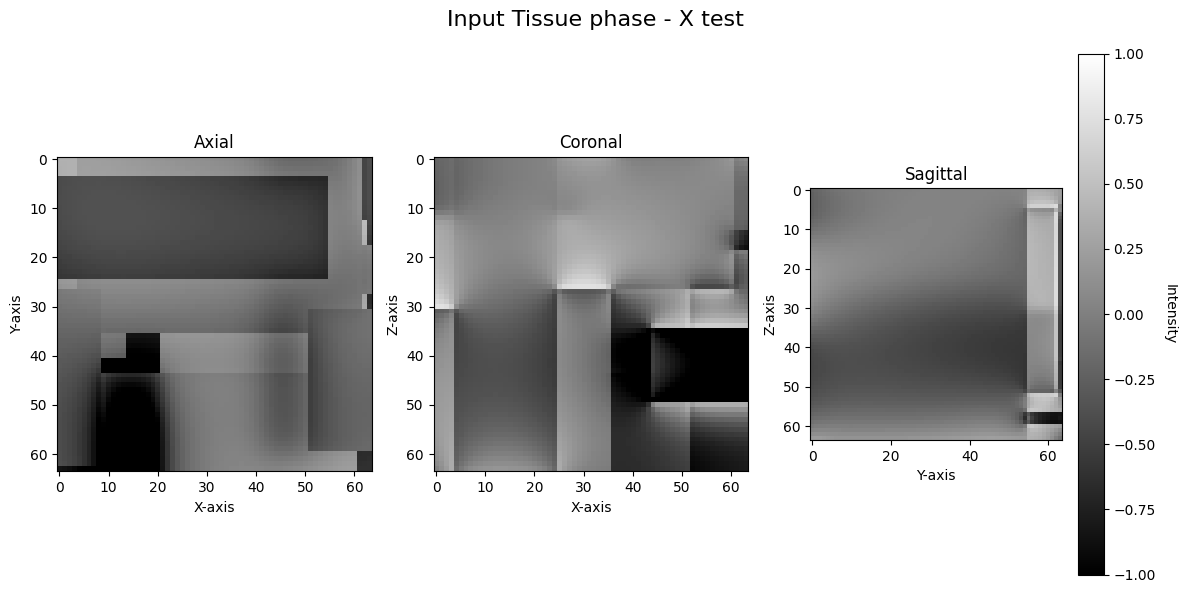

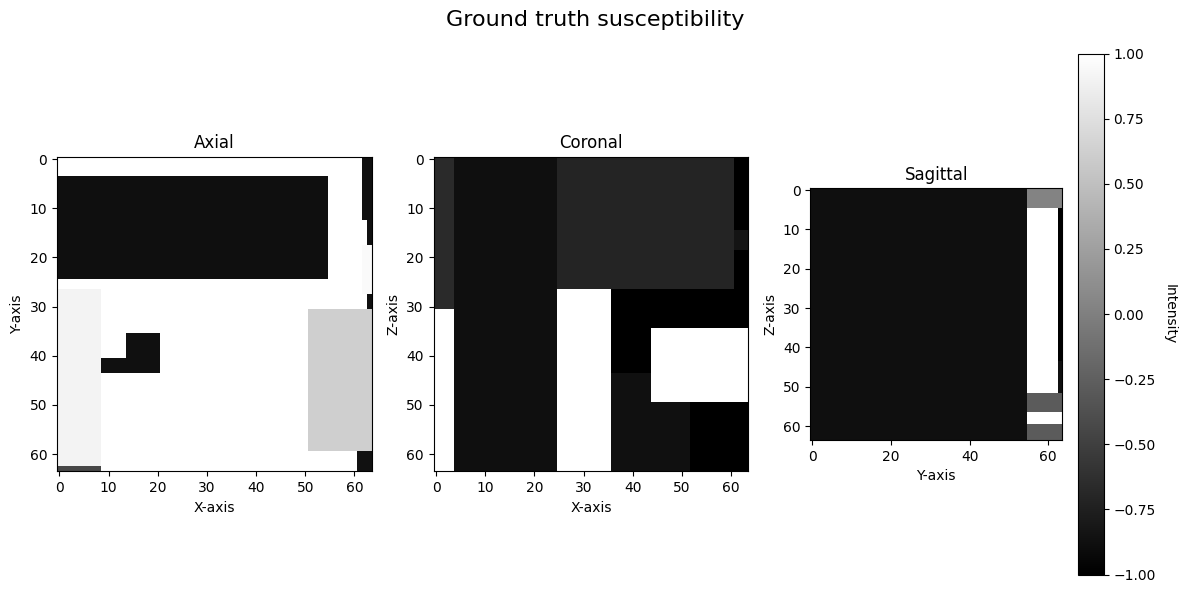

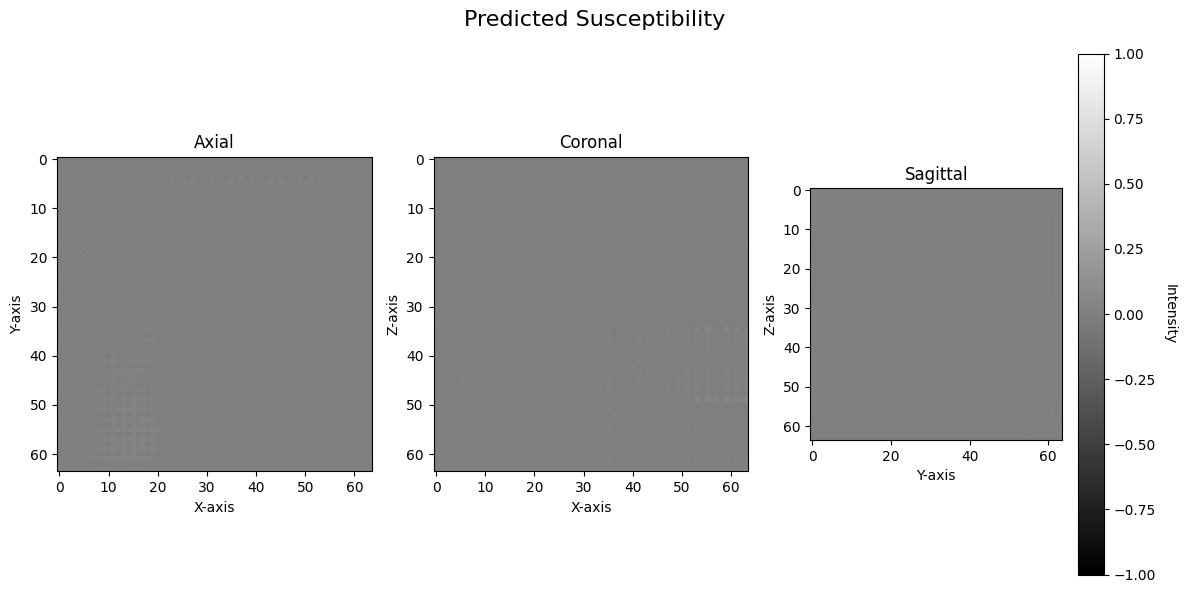

In [19]:
test_patch_nbr = 10
X_test = simulation_fw_patches[np.newaxis, test_patch_nbr,:,:,:, np.newaxis]
print(f"Shape of testing data: {X_test.shape}")

# Getting prediction from model without training
y_pred = unet_model1.predict(X_test)
print(f"Shape of testing data: {X_test.shape}")
view_slices_3d(X_test[0, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Input Tissue phase - X test')
view_slices_3d(simulation_gt_patches[test_patch_nbr, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Ground truth susceptibility')
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Predicted Susceptibility')


###### ***Model 1 - Trainning the model***

In [20]:
 # Directories to store the checkpoints created
checkpoint_path_1 = "checkpoint_model_1/cp-{epoch:04d}.ckpt"
checkpoint_dir1 = os.path.dirname(checkpoint_path_1)

# Callback to save checkpoints
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path_1,
    save_weights_only=True,
    period=PERIOD_TO_STORE,
    verbose=1
)

# Split data into training and validation sets
validation_split = 0.2
split_index = int(len(simulation_fw_patches) * (1 - validation_split))
train_images = tf.expand_dims(simulation_fw_patches[:split_index], 4)
train_labels = tf.expand_dims(simulation_gt_patches[:split_index], 4)
val_images = tf.expand_dims(simulation_fw_patches[split_index:], 4)
val_labels = tf.expand_dims(simulation_gt_patches[split_index:], 4)


# Train the model with validation data
history_1 = unet_model1.fit(
    train_images,
    train_labels,
    epochs=EPOCHS,
    batch_size=30,
    shuffle=True,
    validation_data=(val_images, val_labels),
    callbacks=[cp_callback, MetricsCallback()]
)
loss_history_1 = history_1.history["loss"]

with open('loss_history_1.pickle', 'wb') as f:
    pickle.dump([loss_history_1, EPOCHS], f)




Epoch 1/500
14/14 [==============================] - ETA: 0s - loss: 0.7584
Epoch 1:
  - Loss: 0.7584


KeyError: ignored